# Image Stiching

In [25]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

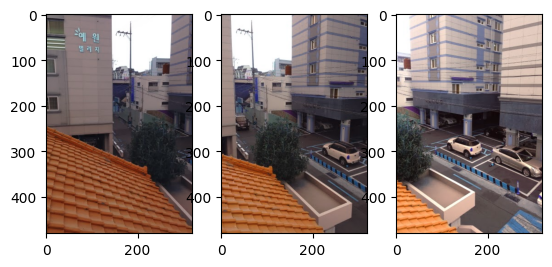

In [26]:
cwd = os.getcwd()
s1 = cv.imread(os.path.join('images','stiching','S1.jpg'))
s2 = cv.imread(os.path.join('images','stiching','S2.jpg'))
s3 = cv.imread(os.path.join('images','stiching','S3.jpg'))
s5 = cv.imread(os.path.join('images','stiching','S5.jpg'))
s6 = cv.imread(os.path.join('images','stiching','S6.jpg'))

# plt.imshow(s1)
# plt.imshow(s2)
# plt.show()

plt.subplot(1,3,1)
plt.imshow(s1)
plt.subplot(1,3,2)
plt.imshow(s2)
plt.subplot(1,3,3)
plt.imshow(s3)
plt.show()  


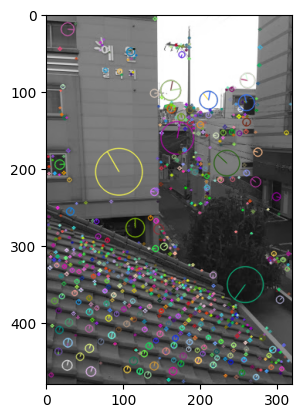

In [27]:
# SIFT detector
sift = cv.SIFT_create()
gs1 = cv.cvtColor(s1, cv.COLOR_BGR2GRAY)

kp1,des1 = sift.detectAndCompute(gs1, None)
img_kp1 = cv.drawKeypoints(gs1, kp1,gs1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img_kp1)
plt.show()

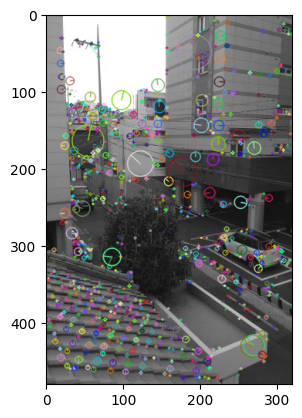

In [28]:
sift2 = cv.SIFT_create()
gs2 = cv.cvtColor(s2, cv.COLOR_BGR2GRAY)
kp2,des2 = sift.detectAndCompute(gs2, None)
img_kp2 = cv.drawKeypoints(gs2, kp2,gs2 ,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_kp2)
plt.show()

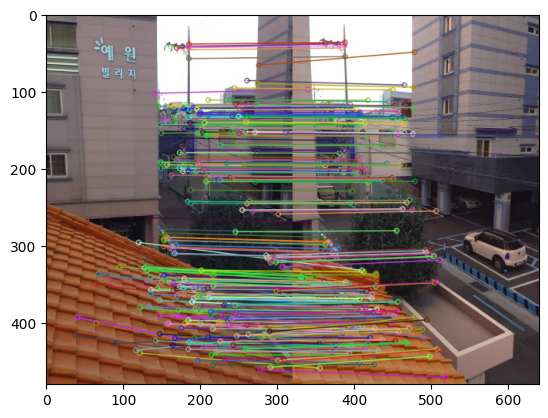

(<matplotlib.image.AxesImage at 0x7fe6c0015090>, None)

In [ ]:
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
 
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
 
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(s1,kp1,s2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
plt.imshow(img3),plt.show()

In [42]:
print(kp1)
print(kp1[0])
print(kp1[0].pt)
print(good)
print(good[0])
print(good[0][0].queryIdx)
print(good[0][0].trainIdx)  

(< cv2.KeyPoint 0x7fe6d21ea850>, < cv2.KeyPoint 0x7fe6d0146b50>, < cv2.KeyPoint 0x7fe6d017fc90>, < cv2.KeyPoint 0x7fe6d017f0f0>, < cv2.KeyPoint 0x7fe6d017eb20>, < cv2.KeyPoint 0x7fe6d017c600>, < cv2.KeyPoint 0x7fe6d017c5a0>, < cv2.KeyPoint 0x7fe6d017ed60>, < cv2.KeyPoint 0x7fe6d017f870>, < cv2.KeyPoint 0x7fe6d017fb40>, < cv2.KeyPoint 0x7fe6d017f180>, < cv2.KeyPoint 0x7fe6d017f9f0>, < cv2.KeyPoint 0x7fe6c86fd0b0>, < cv2.KeyPoint 0x7fe6c86fd110>, < cv2.KeyPoint 0x7fe6c86fec70>, < cv2.KeyPoint 0x7fe6c86ffcf0>, < cv2.KeyPoint 0x7fe6c86ffb70>, < cv2.KeyPoint 0x7fe6c86feb80>, < cv2.KeyPoint 0x7fe6c86fdb30>, < cv2.KeyPoint 0x7fe6c86fe460>, < cv2.KeyPoint 0x7fe6c86ff1e0>, < cv2.KeyPoint 0x7fe6c86fcab0>, < cv2.KeyPoint 0x7fe6c86fccf0>, < cv2.KeyPoint 0x7fe6c86ff6f0>, < cv2.KeyPoint 0x7fe6c86fd200>, < cv2.KeyPoint 0x7fe6c86fcb10>, < cv2.KeyPoint 0x7fe6c86ff480>, < cv2.KeyPoint 0x7fe6c86ffd80>, < cv2.KeyPoint 0x7fe6c86fe9d0>, < cv2.KeyPoint 0x7fe6d0137b40>, < cv2.KeyPoint 0x7fe6d0137120>, < cv2.K

In [54]:
# Cell: Extract points and Compute Homography
if len(good) > 4:
    # Extract location of good matches
    # Note: kp2 is the image we want to warp (train), kp1 is the destination (query)
    # We access m[0] because 'good' is a list of lists from the ratio test structure
    src_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1, 1, 2)

    # Find Homography matrix (H)
    # RANSAC helps outlier rejection
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    
    print("Homography Matrix Calculated")
    print(H)
    
else:
    print("Not enough matches found to compute Homography.")
    H = None

Homography Matrix Calculated
[[ 7.71574582e-01 -1.14640548e-02  1.21778085e+02]
 [-1.33374318e-01  9.28901201e-01  1.25412767e+01]
 [-7.17241775e-04  3.08641944e-06  1.00000000e+00]]


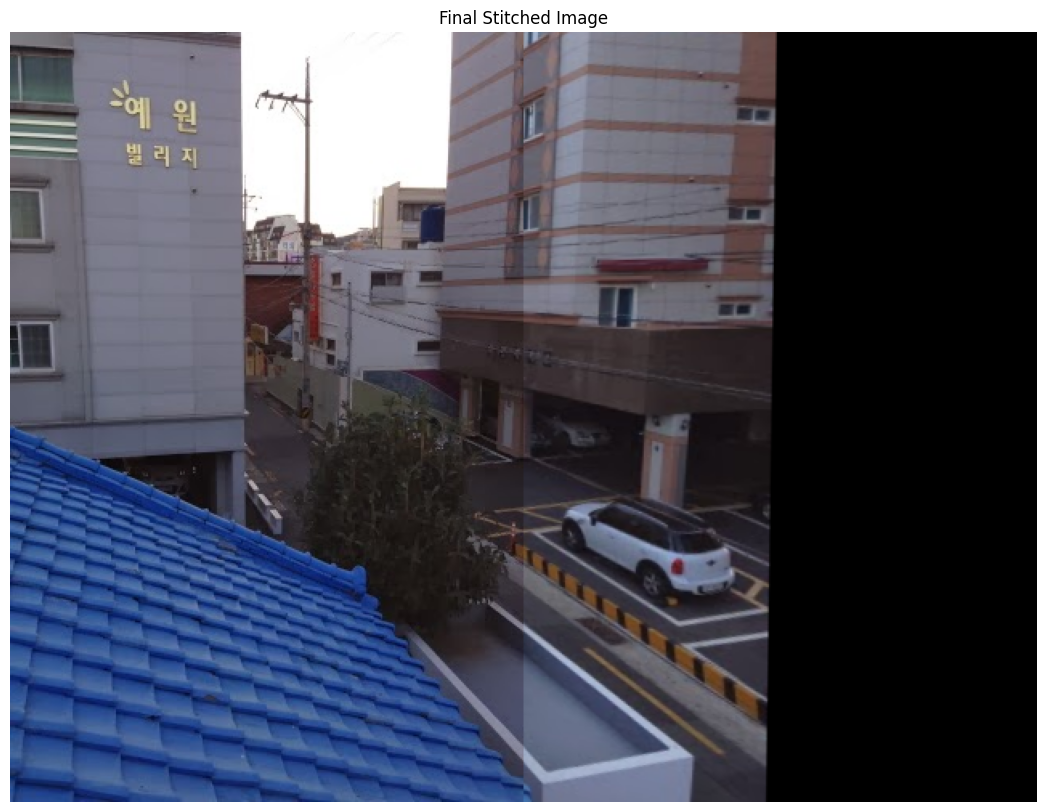

In [ ]:

if H is not None:
    h1, w1 = s1.shape[:2]
    h2, w2 = s2.shape[:2]

    warped_img = cv.warpPerspective(s2, H, (w1 + w2, h1))

    # Place the original s1 image into the warped canvas
    # This overlays s1 on top of the transformed s2
    warped_img[0:h1, 0:w1] = s1

    # Visualizing the result
    # Convert BGR to RGB for matplotlib
    final_output = cv.cvtColor(warped_img, cv.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(final_output)
    plt.title("Final Stitched Image")
    plt.axis('off')
    plt.show()

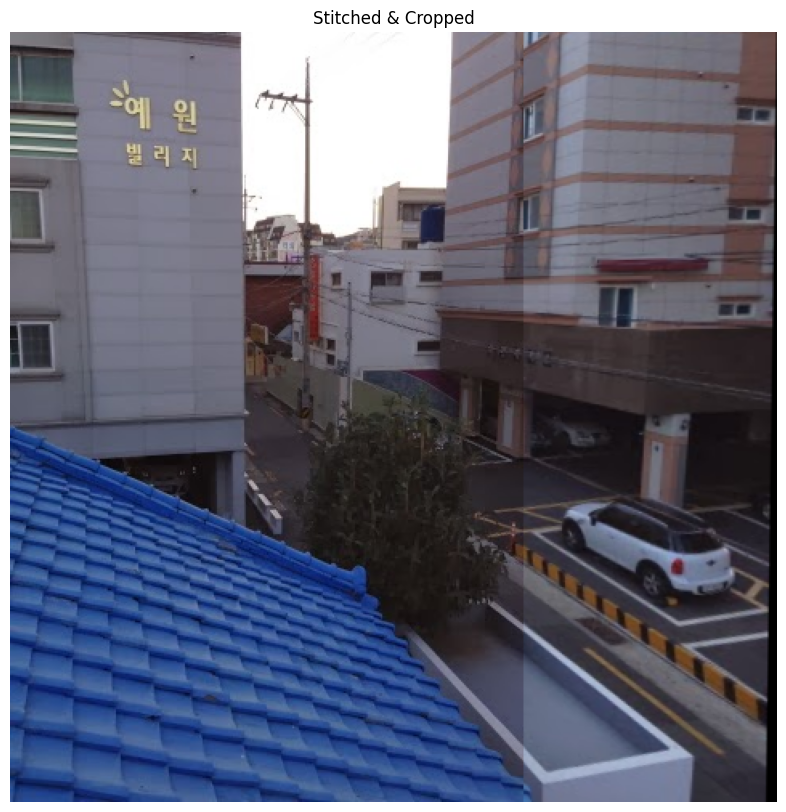

In [34]:
# Cell: Optional - Crop Black Borders (Basic implementation)
# This helps remove the excess black space created by the wide canvas
def crop_black_borders(img):
    # Convert to gray
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Threshold to find non-black pixels
    _, thresh = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
    # Find contours
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get bounding box of the largest contour (the stitched content)
        c = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(c)
        return img[y:y+h, x:x+w]
    return img

if H is not None:
    cropped = crop_black_borders(final_output)
    plt.figure(figsize=(15, 10))
    plt.imshow(cropped)
    plt.title("Stitched & Cropped")
    plt.axis('off')
    plt.show()